In [32]:
import os, glob
import numpy as np

from yellowbrick.target import FeatureCorrelation
from yellowbrick.features import Rank2D
from yellowbrick.features.pca import PCADecomposition

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import h5py
import pandas as pd

from GNN.inputs import split

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Features

In [22]:
# arxiv:1905.08799 talks about this stellar mass cut on page 4 top right column

halo_mass_cut = 1.0e11 #solar masses

## 1.1 SubFind Properties

In [23]:
data_path = '/cosma5/data/dp004/dc-cues1/features/'
hf = h5py.File(data_path + 'halo_features_s99', 'r')

dic_subf = {}
dic_subf["M200c"] = hf["M200c"][:]
dic_subf["R200c"] = hf["R200c"][:]
dic_subf["N_subhalos"] = hf["N_subhalos"][:]
dic_subf["VelDisp"] = hf["VelDisp"][:]
dic_subf["Vmax"] = hf["Vmax"][:]
dic_subf["Spin"] = hf["Spin"][:]
dic_subf["Fsub"] = hf["Fsub"][:]
dic_subf["x_offset"] = hf["x_offset"][:]

df_subf = pd.DataFrame(dic_subf)
df_subf = df_subf[df_subf['M200c'] > halo_mass_cut]

In [26]:
df_subf.sample(n=3, random_state=1)

,M200c,R200c,N_subhalos,VelDisp,Vmax,Spin,Fsub,x_offset
127887,2.833686e+11,138.499893,3,61.716557,118.648613,8.656518,0.014312,0.047662
245330,1.262186e+11,105.767456,2,48.632305,94.996582,7.670080,0.025524,0.042720
91628,2.076151e+11,124.853905,7,52.661438,98.449425,9.881412,0.471288,0.981303


## 1.2 Sownak Bose's Properties

[arxiv:1905.08799](https://arxiv.org/pdf/1905.08799.pdf)

In [24]:
data_path = '/cosma5/data/dp004/hvrn44/HOD/'
hf = h5py.File(data_path + 'HaloProfiles_DMO_z0.00_ext.hdf5', 'r')

# Create Dataframe of integer halos values
dic_bose = {}
for key in hf['Haloes'].keys():
    if (len(hf['Haloes'][key].shape) == 1 and hf['Haloes'][key].shape[0] == 229265):
        print('%s Shape : ' % key, hf['Haloes'][key].shape)
        dic_bose[key] = hf['Haloes'][key][:]

df_bose = pd.DataFrame(dic_bose)
df_bose = df_bose[df_bose['M200'] > halo_mass_cut]

Cnfw Shape :  (229265,)
GroupNumber Shape :  (229265,)
HaloMassDM Shape :  (229265,)
HaloMassGas Shape :  (229265,)
HaloMassStar Shape :  (229265,)
HaloMassTot Shape :  (229265,)
M200 Shape :  (229265,)
Nsubs Shape :  (229265,)
NumPartsBH Shape :  (229265,)
NumPartsDM Shape :  (229265,)
NumPartsGas Shape :  (229265,)
NumPartsStar Shape :  (229265,)
PLIndex Shape :  (229265,)
R200 Shape :  (229265,)
R_Conv Shape :  (229265,)
Rhosnfw Shape :  (229265,)
Rmax Shape :  (229265,)
Spin Shape :  (229265,)
Vmax Shape :  (229265,)
doff Shape :  (229265,)
fsub Shape :  (229265,)


In [27]:
df_bose.sample(n=3, random_state=1)

,Cnfw,GroupNumber,HaloMassDM,HaloMassGas,HaloMassStar,HaloMassTot,M200,Nsubs,NumPartsBH,NumPartsDM,...,NumPartsStar,PLIndex,R200,R_Conv,Rhosnfw,Rmax,Spin,Vmax,doff,fsub
117204,17.206301,117452,2.679356e+11,-999.0,-999.0,26.793564,2.619321e+11,0,-999,5668,...,-999,-1.960787,104.059860,7.253173,5.047428e+07,0.020974,0.022141,136.689542,0.036462,0.000000
214827,8.614289,226462,1.277280e+11,-999.0,-999.0,12.772797,1.100011e+11,0,-999,2702,...,-999,-2.296759,77.922707,7.972175,8.384557e+06,0.015152,0.022071,91.369410,0.259511,0.000000
33938,5.618971,33938,1.075052e+12,-999.0,-999.0,107.505157,6.368908e+11,4,-999,22742,...,-999,-1.568762,139.930954,7.383672,3.131773e+06,0.058083,0.032558,156.036678,27.311872,0.022712


# 2 Feature Importance

## 2.1 Pearson correlation score

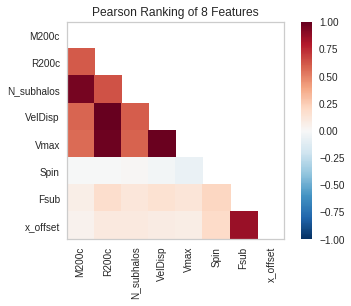

In [5]:
visualizer = Rank2D(features=feature_names, algorithm='pearson')

visualizer.fit(features, labels)
visualizer.transform(features)  
visualizer.poof()  

## 2.2 PCA - variance ratios in scaled dataset

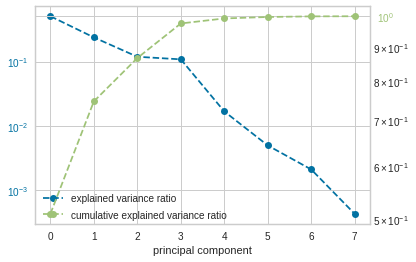

In [45]:
scaler = StandardScaler()

scaler_data = scaler.fit_transform(df_subf)
pca = PCA().fit(scaler_data)

# Plot
fig, ax1 = plt.subplots()

# Axis 1
ax1.semilogy(
    pca.explained_variance_ratio_,
    '--bo',
    label='explained variance ratio',
)
color =  ax1.lines[0].get_color()
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax1.set_xlabel('principal component')
plt.legend(loc=(0.01, 0.075))

# Axis 2
ax2 = ax1.twinx()
ax2.semilogy(
    pca.explained_variance_ratio_.cumsum(),
    '--go',
    label='cumulative explained variance ratio',
)
for tl in ax2.get_yticklabels():
    tl.set_color('g')

plt.legend(loc=(0.01, 0))

## 2.3 PCA - inverse & biases

In [50]:
n_comp = 7
pca = PCA(n_components=n_comp)

data_scaled = StandardScaler().fit_transform(df_subf)


pca_data = pca.fit_transform(data_scaled)
pca_inv_data = pca.inverse_transform(np.eye(n_comp))

Text(33,0.5,'principal component')

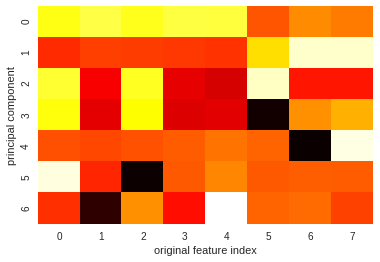

In [53]:
# Inverse

sns.heatmap(
    #np.log(pca_inv_data),
    pca.inverse_transform(np.eye(n_comp)),
    cmap="hot",
    cbar=False,
)
plt.xlabel('original feature index')
plt.ylabel('principal component')

Text(0.5,0,'feature index')

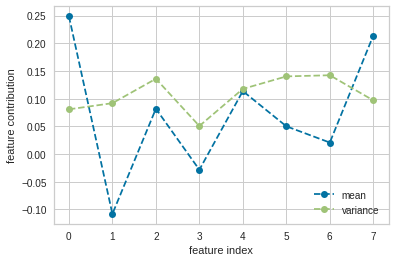

In [54]:
# Biases

plt.plot(
    pca_inv_data.mean(axis=0), 
    '--o',
    label='mean',
)
plt.plot(
    np.square(pca_inv_data.std(axis=0)),
    '--o',
    label='variance',
)
plt.legend(loc='best')
plt.ylabel('feature contribution')
plt.xlabel('feature index')